# The relationship between US interest rates and public debt in developing countries

## Setup of the Workspace

### Packages

In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os 

#from sqlalchemy import create_engine

### Paths

In [158]:
ROOT = os.path.dirname(os.getcwd())

PATH_DATA = os.path.join(ROOT, 'data')


## Data

### FRED
contains data on US interest rates

In [159]:
# Download and read the CSV directly into a DataFrame
#df_fred = pd.read_csv("C:/Users/Maude/OneDrive/Documents/etudes/UZH/PhD/2nd year/first semester/programming/project/data/FEDFUNDS.csv")

df_fred_raw = pd.read_csv(os.path.join(PATH_DATA, 'FEDFUNDS.csv')) #.replace('\\', '/'))



#convert monthly data to yearly data

## Convert the date column to datetime format
df_fred_raw['DATE'] = pd.to_datetime(df_fred_raw['DATE'])

## Filter the DataFrame to include only rows where the month is January
df_fred_raw_year = df_fred_raw[df_fred_raw['DATE'].dt.month == 1]

## Extract and keep only the year
df_fred_raw_year['DATE'] = df_fred_raw_year['DATE'].dt.year



#convert data to same format as WB to append

## Add columns for 'Country Name' and 'Country Code'
df_fred_raw_year['Country Name'] = 'United States'

df_fred_raw_year['Country Code'] = 'USA'

## Rename the columns
df_fred_raw_year.rename(columns={'DATE': 'YEAR', 'FEDFUNDS': 'Series Name'}, inplace=True)

df_fred_raw_year.head(10)

## Convert the DataFrame from long format to wide format
df_fred_raw_wide = df_fred_raw_year.pivot(index=['Country Name', 'Country Code'], columns='YEAR', values='Series Name')



## Add a new column 'Series name' with the value 'Interest rate'
df_fred_raw_wide['Series Name'] = 'Interest rate'
df_fred_raw_wide['Country Name'] = 'United States'
df_fred_raw_wide['Country Code'] = 'USA'

## Drop the columns 1955, 1956, 1957, 1958, 1959, 2024
df_fred_raw_wide.drop(columns=[1955, 1956, 1957, 1958, 1959, 2024], inplace=True)

df_fred_raw_wide.head(10)




C:\Users\Maude\AppData\Local\Temp\ipykernel_13684\239376244.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fred_raw_year['DATE'] = df_fred_raw_year['DATE'].dt.year
C:\Users\Maude\AppData\Local\Temp\ipykernel_13684\239376244.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fred_raw_year['Country Name'] = 'United States'
C:\Users\Maude\AppData\Local\Temp\ipykernel_13684\239376244.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

,YEAR,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2017,2018,2019,2020,2021,2022,2023,Series Name,Country Name,Country Code
Country Name,Country Code,,,,,,,,,,,,,,,,,,,,,
United States,USA,3.99,1.45,2.15,2.92,3.48,3.9,4.42,4.94,4.61,6.3,...,0.65,1.41,2.4,1.55,0.09,0.08,4.33,Interest rate,United States,USA


### World Bank


contains data on GNI, GNI per capita, population, external debt stock (% of GNI), external debt stock, official exchange rate, currency composition of PPG

In [160]:
df_WB_raw = pd.read_csv(os.path.join(PATH_DATA, 'World_Bank_data.csv')) #.replace('\\', '/'))
df_WB_raw.head()
#df_WB_raw.shape


,Country Name,Country Code,Series Name,Series Code,1960 [YR1960],1961 [YR1961],1962 [YR1962],1963 [YR1963],1964 [YR1964],1965 [YR1965],...,2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],2021 [YR2021],2022 [YR2022],2023 [YR2023]
0,Afghanistan,AFG,External debt stocks (% of GNI),DT.DOD.DECT.GN.ZS,..,..,..,..,..,..,...,12.3049882430693,13.4908300391384,14.1470450328557,14.5133427332625,14.6424246274665,13.9496520911751,15.1208585234171,24.7744403222298,..,..
1,Afghanistan,AFG,"External debt stocks, total (DOD, current US$)",DT.DOD.DECT.CD,..,..,..,..,..,..,...,2529865267.8,2596917266.2,2596050086.4,2751986638.9,2678760424.2,2661685956.5,3040072312.4,3555784339.6,3393247241.7,..
2,Afghanistan,AFG,"Official exchange rate (LCU per US$, period av...",PA.NUS.FCRF,17.1965606878624,17.1965606878624,17.1965606878624,35.1096447377192,38.6922615476905,38.6922615476905,...,57.2475,61.1434615416667,67.8660857692308,68.0269040822312,72.083247177304,77.7379491783367,76.8135364354897,..,..,..
3,Afghanistan,AFG,GNI (current US$),NY.GNP.MKTP.CD,548888848.888889,560000022.222222,557777806.666667,766666706.666667,815555562.222222,1026666677.77778,...,20559672324.9094,19249499438.7455,18350475875.2999,18961769787.4548,18294513957.5523,19080662010.7479,20105156769.1907,14352632363.74,14545219074.5763,..
4,Afghanistan,AFG,"GNI per capita, PPP (current international $)",NY.GNP.PCAP.PP.CD,..,..,..,..,..,..,...,2240,2300,2250,2360,2470,2630,2590,2150,2100,..


In [161]:
df_WB_comp_raw = pd.read_csv(os.path.join(PATH_DATA, 'World_Bank_composition.csv')) #.replace('\\', '/'))
df_WB_comp_raw.shape
df_WB_comp_raw.head()

,Country Name,Country Code,Counterpart-Area Name,Counterpart-Area Code,Series Name,Series Code,1970 [YR1970],1971 [YR1971],1972 [YR1972],1973 [YR1973],...,2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],2021 [YR2021],2022 [YR2022],2023 [YR2023]
0,Afghanistan,AFG,World,WLD,"Currency composition of PPG debt, U.S. dollars...",DT.CUR.USDL.ZS,..,..,..,..,...,72.119,71.5365,71.6963,71.4215,71.4005,70.7864,70.6726,71.0905,71.5724,..
1,Albania,ALB,World,WLD,"Currency composition of PPG debt, U.S. dollars...",DT.CUR.USDL.ZS,..,..,..,..,...,37.0724,33.7267,34.6949,38.6747,39.4211,41.9899,37.2818,34.3902,35.4623,..
2,Algeria,DZA,World,WLD,"Currency composition of PPG debt, U.S. dollars...",DT.CUR.USDL.ZS,36.9648,41.1115,43.7869,39.446,...,12.1137,10.7537,3.4616,1.2213,0.0891,0.0084,0.0000,0.0000,0.0000,..
3,Angola,AGO,World,WLD,"Currency composition of PPG debt, U.S. dollars...",DT.CUR.USDL.ZS,..,..,..,..,...,90.8066,91.2840,91.8073,91.0572,91.7833,91.6605,90.7719,90.4606,90.5126,..
4,Argentina,ARG,World,WLD,"Currency composition of PPG debt, U.S. dollars...",DT.CUR.USDL.ZS,45.6812,49.7009,52.5138,47.255,...,69.7062,69.6138,66.6773,67.5774,71.6776,73.6521,89.3016,90.7706,91.4307,..


In [162]:
### Appended dataframes

# Append WB dataframes
WB_df_raw = pd.concat([df_WB_raw, df_WB_comp_raw], ignore_index=True)

# Delete columns Counterpart-Area Code and Counterpart-Area Name

WB_df_raw_del = WB_df_raw.drop(columns=['Counterpart-Area Code', 'Counterpart-Area Name'])

# Rename years columns

## Create a dictionary to map old column names to new column names
rename_dict = {col: col.split('[')[0] for col in WB_df_raw_del.columns if '[' in col}

## Rename the columns
WB_df_raw_del.rename(columns=rename_dict, inplace=True)

# Create a dictionary to map old column names to new column names
rename_dict = {f'{year} ': year for year in range(1960, 2024)}

# Rename the columns
WB_df_raw_del.rename(columns=rename_dict, inplace=True)

WB_df_raw_del.head()


,Country Name,Country Code,Series Name,Series Code,1960,1961,1962,1963,1964,1965,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Afghanistan,AFG,External debt stocks (% of GNI),DT.DOD.DECT.GN.ZS,..,..,..,..,..,..,...,12.3049882430693,13.4908300391384,14.1470450328557,14.5133427332625,14.6424246274665,13.9496520911751,15.1208585234171,24.7744403222298,..,..
1,Afghanistan,AFG,"External debt stocks, total (DOD, current US$)",DT.DOD.DECT.CD,..,..,..,..,..,..,...,2529865267.8,2596917266.2,2596050086.4,2751986638.9,2678760424.2,2661685956.5,3040072312.4,3555784339.6,3393247241.7,..
2,Afghanistan,AFG,"Official exchange rate (LCU per US$, period av...",PA.NUS.FCRF,17.1965606878624,17.1965606878624,17.1965606878624,35.1096447377192,38.6922615476905,38.6922615476905,...,57.2475,61.1434615416667,67.8660857692308,68.0269040822312,72.083247177304,77.7379491783367,76.8135364354897,..,..,..
3,Afghanistan,AFG,GNI (current US$),NY.GNP.MKTP.CD,548888848.888889,560000022.222222,557777806.666667,766666706.666667,815555562.222222,1026666677.77778,...,20559672324.9094,19249499438.7455,18350475875.2999,18961769787.4548,18294513957.5523,19080662010.7479,20105156769.1907,14352632363.74,14545219074.5763,..
4,Afghanistan,AFG,"GNI per capita, PPP (current international $)",NY.GNP.PCAP.PP.CD,..,..,..,..,..,..,...,2240,2300,2250,2360,2470,2630,2590,2150,2100,..


### Append FRED and WB 

In [163]:
data_FRED_WB_wide = pd.concat([WB_df_raw_del, df_fred_raw_wide], ignore_index=True)

# Replace values equal to '..' with NaN
data_FRED_WB_wide.replace('..', np.nan, inplace=True)

# Drop rows where the "Country Code" column contains NaN
data_FRED_WB_wide.dropna(subset=['Country Code'], inplace=True)

# Drop column Series Code
data_FRED_WB_wide.drop(columns='Series Code', inplace=True)

# Convert the DataFrame from wide format to long format
data_FRED_WB_long = pd.melt(data_FRED_WB_wide, id_vars=['Country Name', 'Country Code', 'Series Name'], var_name='Year', value_name='Value')



data_FRED_WB_wide.head(10)


,Country Name,Country Code,Series Name,1960,1961,1962,1963,1964,1965,1966,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Afghanistan,AFG,External debt stocks (% of GNI),NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.3049882430693,13.4908300391384,14.1470450328557,14.5133427332625,14.6424246274665,13.9496520911751,15.1208585234171,24.7744403222298,NaN,NaN
1,Afghanistan,AFG,"External debt stocks, total (DOD, current US$)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2529865267.8,2596917266.2,2596050086.4,2751986638.9,2678760424.2,2661685956.5,3040072312.4,3555784339.6,3393247241.7,NaN
2,Afghanistan,AFG,"Official exchange rate (LCU per US$, period av...",17.1965606878624,17.1965606878624,17.1965606878624,35.1096447377192,38.6922615476905,38.6922615476905,38.6922615476905,...,57.2475,61.1434615416667,67.8660857692308,68.0269040822312,72.083247177304,77.7379491783367,76.8135364354897,NaN,NaN,NaN
3,Afghanistan,AFG,GNI (current US$),548888848.888889,560000022.222222,557777806.666667,766666706.666667,815555562.222222,1026666677.77778,1428888871.11111,...,20559672324.9094,19249499438.7455,18350475875.2999,18961769787.4548,18294513957.5523,19080662010.7479,20105156769.1907,14352632363.74,14545219074.5763,NaN
4,Afghanistan,AFG,"GNI per capita, PPP (current international $)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2240,2300,2250,2360,2470,2630,2590,2150,2100,NaN
5,Afghanistan,AFG,"Population, total",8622466,8790140,8969047,9157465,9355514,9565147,9783147,...,32716210,33753499,34636207,35643418,36686784,37769499,38972230,40099462,41128771,42239854
6,Albania,ALB,External debt stocks (% of GNI),NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,63.7664595243345,73.3135322383179,70.651576129568,75.0981975562841,63.7541024238069,61.015763100267,70.2589295385165,62.5241703121563,56.3023228650404,NaN
7,Albania,ALB,"External debt stocks, total (DOD, current US$)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8512452310,8447046910.5,8516222980.3,9801454504.1,9651086366.7,9274545228.5,10477366100.7,11054877741.5,10454989641.6,NaN
8,Albania,ALB,"Official exchange rate (LCU per US$, period av...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,105.48,125.961666666667,124.1425,119.1,107.989166666667,109.850833333333,108.65,103.52,113.041666666667,100.645
9,Albania,ALB,GNI (current US$),NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13349419700.4171,11521811393.6203,12053832974.203,13051517643.6213,15137984850.8323,15200244588.0406,14912504601.9328,17680966714.6445,18569375310.9639,22674870567.8374


### Classification of low income countries

The data provided by the World Bank contains information on the geography and economic development of countries. This data will be merged to the datasets `data_FRED_WB_wide` and `data_FRED_WB_long`.

In [164]:

# Open the World Bank classification file
WB_class_raw = pd.read_excel(os.path.join(PATH_DATA, 'World_Bank_classification.xlsx'))

# Drop the column "Lending category"

WB_class_raw.drop(columns='Lending category', inplace=True)

# Rename the columns "Economy" and "Code"

WB_class_raw.rename(columns={'Economy': 'Country Name', 'Code': 'Country Code'}, inplace=True)

# Merge the data_FRED_WB_wide DataFrame with the WB_class_raw DataFrame

data_FRED_WB_wide = pd.merge(data_FRED_WB_wide, WB_class_raw, on=['Country Name', 'Country Code'], how='left')

# Merge the data_FRED_WB_long DataFrame with the WB_class_raw DataFrame

data_FRED_WB_long = pd.merge(data_FRED_WB_long, WB_class_raw, on=['Country Name', 'Country Code'], how='left')

data_FRED_WB_long.head(10)
#os.path.join(PATH_DATA, 'World_Bank_classification.xlsx')

,Country Name,Country Code,Series Name,Year,Value,Region,Income group
0,Afghanistan,AFG,External debt stocks (% of GNI),1960,NaN,South Asia,Low income
1,Afghanistan,AFG,"External debt stocks, total (DOD, current US$)",1960,NaN,South Asia,Low income
2,Afghanistan,AFG,"Official exchange rate (LCU per US$, period av...",1960,17.1965606878624,South Asia,Low income
3,Afghanistan,AFG,GNI (current US$),1960,548888848.888889,South Asia,Low income
4,Afghanistan,AFG,"GNI per capita, PPP (current international $)",1960,NaN,South Asia,Low income
5,Afghanistan,AFG,"Population, total",1960,8622466,South Asia,Low income
6,Albania,ALB,External debt stocks (% of GNI),1960,NaN,Europe & Central Asia,Upper middle income
7,Albania,ALB,"External debt stocks, total (DOD, current US$)",1960,NaN,Europe & Central Asia,Upper middle income
8,Albania,ALB,"Official exchange rate (LCU per US$, period av...",1960,NaN,Europe & Central Asia,Upper middle income
9,Albania,ALB,GNI (current US$),1960,NaN,Europe & Central Asia,Upper middle income


In [167]:
# create an additional wide format dataframe

## Convert 'Value' and 'Year' column to numeric, coercing errors to NaN

data_FRED_WB_long['Year'] = pd.to_numeric(data_FRED_WB_long['Year'], errors='coerce')
data_FRED_WB_long['Value'] = pd.to_numeric(data_FRED_WB_long['Value'], errors='coerce')

## Create a pivot table to transform the data from long format to wide format

df_FRED_WB_wide2 = data_FRED_WB_long.pivot_table(index=['Country Name', 'Country Code', 'Year', 'Region', 'Income group'], columns='Series Name', values='Value').reset_index()
df_FRED_WB_wide2.head(10)


Columns in data_FRED_WB_long:
Index(['Country Name', 'Country Code', 'Series Name', 'Year', 'Value',
       'Region', 'Income group'],
      dtype='object')
The 'Region' column is present in the DataFrame.


Series Name,Country Name,Country Code,Year,Region,Income group,"Currency composition of PPG debt, U.S. dollars (%)",External debt stocks (% of GNI),"External debt stocks, total (DOD, current US$)",GNI (current US$),"GNI per capita, PPP (current international $)",Interest rate,"Official exchange rate (LCU per US$, period average)","Population, total"
0,Afghanistan,AFG,1960,South Asia,Low income,NaN,NaN,NaN,5.488888e+08,NaN,NaN,17.196561,8622466.0
1,Afghanistan,AFG,1961,South Asia,Low income,NaN,NaN,NaN,5.600000e+08,NaN,NaN,17.196561,8790140.0
2,Afghanistan,AFG,1962,South Asia,Low income,NaN,NaN,NaN,5.577778e+08,NaN,NaN,17.196561,8969047.0
3,Afghanistan,AFG,1963,South Asia,Low income,NaN,NaN,NaN,7.666667e+08,NaN,NaN,35.109645,9157465.0
4,Afghanistan,AFG,1964,South Asia,Low income,NaN,NaN,NaN,8.155556e+08,NaN,NaN,38.692262,9355514.0
5,Afghanistan,AFG,1965,South Asia,Low income,NaN,NaN,NaN,1.026667e+09,NaN,NaN,38.692262,9565147.0
6,Afghanistan,AFG,1966,South Asia,Low income,NaN,NaN,NaN,1.428889e+09,NaN,NaN,38.692262,9783147.0
7,Afghanistan,AFG,1967,South Asia,Low income,NaN,NaN,NaN,1.708889e+09,NaN,NaN,38.692262,10010030.0
8,Afghanistan,AFG,1968,South Asia,Low income,NaN,NaN,NaN,1.402222e+09,NaN,NaN,38.692262,10247780.0
9,Afghanistan,AFG,1969,South Asia,Low income,NaN,NaN,NaN,1.437778e+09,NaN,NaN,38.692262,10494489.0


A database aggregated by `income group` and weighted by `Population` will be created

In [176]:
# Define a function to compute the weighted mean
def weighted_mean(df, value_col, weight_col):
    return (df[value_col] * df[weight_col]).sum() / df[weight_col].sum()

# List of columns to compute the weighted mean for, excluding non-numeric columns

value_columns = df_FRED_WB_wide2.columns.difference(['Country Name', 'Country Code', 'Year', 'Region', 'Income group', 'Population, total', 'Series Name'])

# Group by 'Income group' and compute the weighted mean for each column
data_FRED_WB_agg = df_FRED_WB_wide2.groupby(['Income group','Year']).apply(
    lambda x: pd.Series({col: weighted_mean(x, col, 'Population, total') for col in value_columns})
).reset_index()

# Display the aggregated DataFrame


C:\Users\Maude\AppData\Local\Temp\ipykernel_13684\315507377.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_FRED_WB_agg = df_FRED_WB_wide2.groupby(['Income group','Year']).apply(


## Analysis

In this analysis, I explore whether the US interest rate is closely related to the public debt of developing countries. The idea would be that an increase in the US interest rates attracts foreign investment in the US, which appreciates the dollar relative to other currencies. As a consequence, countries whose debt is largely denominated in US dollar and whose local currency depreciated relative to the US dollar should observe an increase in the real value of their public debt. Indeed, the repayment of the public debt in their local currency has increased as the local currency depreciated.

I focus on low income and lower middle income countries because they are already the most at risk with their public debt due to little fiscal capacity. (add stuffs from research proposal)

### Descriptive graphs

#### The relationship between US interest rates and exchange rates in developing countries

   Income group  Year  Currency composition of PPG debt, U.S. dollars (%)  \
64   Low income  1960                                                0.0    
65   Low income  1961                                                0.0    
66   Low income  1962                                                0.0    
67   Low income  1963                                                0.0    
68   Low income  1964                                                0.0    
69   Low income  1965                                                0.0    
70   Low income  1966                                                0.0    
71   Low income  1967                                                0.0    
72   Low income  1968                                                0.0    
73   Low income  1969                                                0.0    

    External debt stocks (% of GNI)  \
64                              0.0   
65                              0.0   
66                              0.0

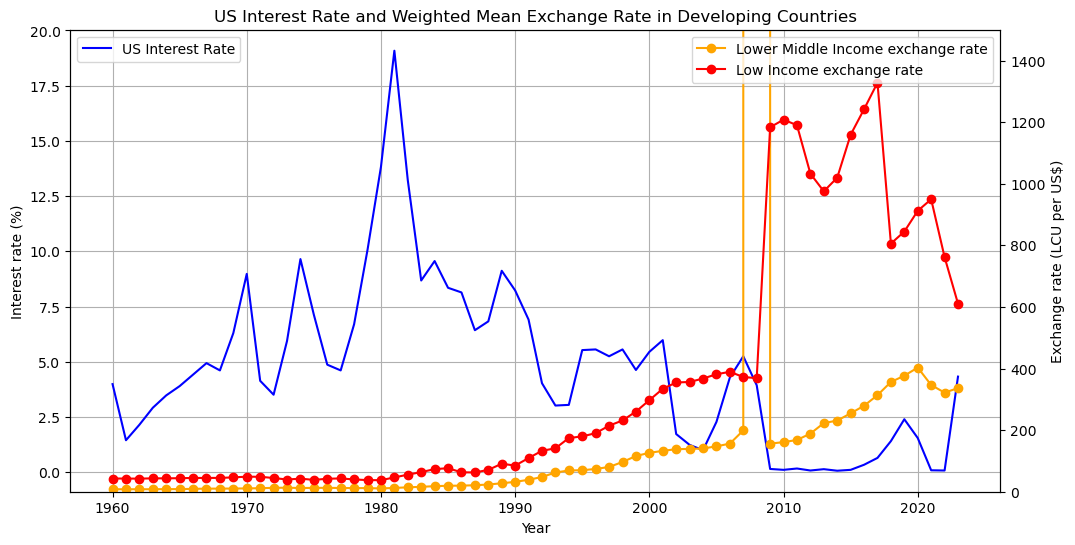

In [184]:
# plot the US interest rate over time and the currencies of low income countries as well as of lower middle income countries

## Filter the data_FRED_WB_wide2 DataFrame to include only rows where the "Country Name" column is equal to "United States" and keep only the columns Country name, Country code, Year and interest rate

df_USA_interest_rate = df_FRED_WB_wide2[(df_FRED_WB_wide2['Country Name'] == 'United States') & (df_FRED_WB_wide2['Interest rate'].notnull())]

df_USA_interest_rate.head(10)

## Filter the data_FRED_WB_agg to include only rows where the "Income group" column is equal to "Low income" and "Lower middle income"

df_low_income_agg = data_FRED_WB_agg[data_FRED_WB_agg['Income group'] == 'Low income']

df_lower_middle_income_agg = data_FRED_WB_agg[data_FRED_WB_agg['Income group'] == 'Lower middle income']

print(df_low_income_agg.head(10))

## Plot

# Plot the US interest rate and weighted mean exchange rate over time
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the US interest rate on the first y-axis
ax1.plot(df_USA_interest_rate['Year'], df_USA_interest_rate['Interest rate'], color='blue', label='US Interest Rate')
ax1.set_xlabel('Year')
ax1.set_ylabel('Interest rate (%)')
ax1.set_title('US Interest Rate and Weighted Mean Exchange Rate in Developing Countries')
ax1.grid()
ax1.legend(loc='upper left')

# Create a second y-axis for the exchange rates
ax2 = ax1.twinx()
ax2.plot(df_lower_middle_income_agg['Year'], df_lower_middle_income_agg['Official exchange rate (LCU per US$, period average)'], marker='o', color='orange', label='Lower Middle Income exchange rate')
ax2.plot(df_low_income_agg['Year'], df_low_income_agg['Official exchange rate (LCU per US$, period average)'], marker='o', color='red', label='Low Income exchange rate')
ax2.set_ylabel('Exchange rate (LCU per US$)')
ax2.set_ylim(0, 1500)  # 2008 is an outlier for lower middle income countries because of Zimbabwe
ax2.legend(loc='upper right')

plt.show()


First, I investigate the relationship between the US interest rates and the exchange rates in developing countries. In theory, if exchange rates are floating, the US interest rates and the exchange rates should be positively correlated: A rise in the US interest rates would increase foreign demand for investment in the US, and therefore, increase the demand for US dollar relative to other currencies. The dollar would appreciate and other currencies would depreciate relative to the dollar, which translates into an increase in `LCU per US$`.

The correlation between US interest rate and exchange rates in developing countries is not clear.

Between 1960 and 1990, the US interest rates are at high levels and pretty volatile. By contrast, exchange rates in low income countres and lower middle income countries are at low levels in historic perspective and not volatile. The stability might result from fixed exchange rate regimes. It is important to note that during this period, exchange rates have an increasing trend, but the scale of the graph does not show this trend clearly.

After 1990, the US interest rates is at lower levels and less volatile. From 2009, it even reached the zero lower bound for many periods. Exchange rates are on a clear increasing trend. The exchange rates in lower middle income countries have a clear and steady increasing trend. With the exception of 2008, where it explodes, but this is driven by Zimbabwe and the huge loss of value of its currency. The exchange rates of low income countries also have this steady increasing trend until 2008. After the Great Financial Crisis, they reach very high levels and are volatile. 

#### The relationship between exchange rates and external debt in developing countries

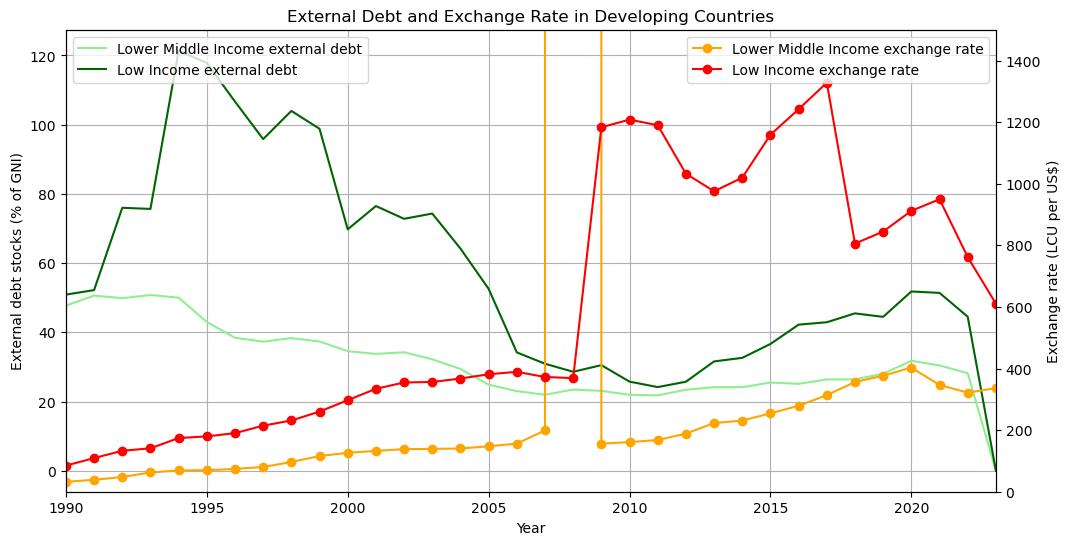

In [188]:
# Plot the external debt and weighted mean exchange rate over time
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the external debt on the first y-axis
ax1.plot(df_lower_middle_income_agg['Year'], df_lower_middle_income_agg['External debt stocks (% of GNI)'], color='lightgreen', label='Lower Middle Income external debt')
ax1.plot(df_low_income_agg['Year'], df_low_income_agg['External debt stocks (% of GNI)'], color='darkgreen', label='Low Income external debt')

ax1.set_xlabel('Year')
ax1.set_ylabel('External debt stocks (% of GNI)')
ax1.set_title('External Debt and Exchange Rate in Developing Countries')
ax1.grid()
ax1.legend(loc='upper left')
ax1.set_xlim(1990, 2023)  # Set x-axis limits because exchange rate too constant before 1990

# Create a second y-axis for the exchange rates
ax2 = ax1.twinx()
ax2.plot(df_lower_middle_income_agg['Year'], df_lower_middle_income_agg['Official exchange rate (LCU per US$, period average)'], marker='o', color='orange', label='Lower Middle Income exchange rate')
ax2.plot(df_low_income_agg['Year'], df_low_income_agg['Official exchange rate (LCU per US$, period average)'], marker='o', color='red', label='Low Income exchange rate')
ax2.set_ylabel('Exchange rate (LCU per US$)')
ax2.set_ylim(0, 1500)  # 2008 is an outlier for lower middle income countries because of Zimbabwe
ax2.legend(loc='upper right')

plt.show()

I study the link between external debt stock and exchange rate in developing countries. Theoretically, external debt and exchange rate should be positively correlated.Indeed, if exchange rate increases, which corresponds to a depreciation of the local currency, then external debt should increase assuming that a large proportion of external debt is in US dollar.

Low income countries' external debt rises a lot after 1990 as their exchange rate steadily increases. However, the explosion of the external debt until 1995 is too big to be explained mainly by the exchange rate. An important event must have triggered the sharp increase in external debt. Then, the external debt has been decreasing a lot until 2012 whereas the exchange rate continues its steady increase and even jumps upwards in 2009. Here, the correlation is clearly negative. From 2012, external debt has been slowly rising and exchange rates were at high levels as well as very volatile in historical perspective.

Lower middle income countries' external has been steadily decreasing until 2011 while the exchange rate was steadily increasing. between 2012-2020, the external debt has been slightly increasing and the exchange rate continued its steady increasing trend. After 2020, I observe a decrease in the external debt and exchange rate. 